In [1]:
import numpy as np
import brainio
import sys
sys.path.append('/home3/ebrahim/what-is-brainscore/')
from helper_funcs import combine_MSE_across_folds
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
import copy

In [2]:
base = '/home3/ebrahim/what-is-brainscore/results_all/'
resultsFolder = f'{base}results_pereira/'

In [3]:
nc_file_pereira = '/home3/ebrahim/what-is-brainscore/pereira_data/Pereira_data.nc'
pereira_data = brainio.assemblies.DataAssembly.from_files(nc_file_pereira)

In [4]:
language_idxs = np.asarray(pereira_data.atlas=='language')

In [5]:
dataset = 'pereira'

In [6]:
key_intercept = 'intercept_only'
model_res_intercept = dict(np.load(f"{resultsFolder}{dataset}_{key_intercept}.npz"))
y_test = model_res_intercept['y_test_folds']
mse_intercept_only = combine_MSE_across_folds(model_res_intercept['mse_stored'], dataset='pereira')
mse_intercept_only.mean()

1.9021095300940767

In [7]:
key = 'gpt_glove_surprisal_position_kern'
val = 'layer1_1000'
model_res = dict(np.load(f"{resultsFolder}{dataset}_{key}_{val}.npz"))
key = "glove_surprisal_position"
val = 'layer1_1000'
model_res_glove = dict(np.load(f"{resultsFolder}{dataset}_{key}_{val}.npz"))

In [8]:
y_hat_LI = model_res_glove['y_hat_folds']
y_hat_LI_gpt = model_res['y_hat_folds']

In [9]:
# real R2 for each model
mse_LI_gpt = mean_squared_error(y_hat_LI_gpt, y_test, multioutput='raw_values')
mse_LI = mean_squared_error(y_hat_LI, y_test, multioutput='raw_values')

r2_LI_gpt = 1 - mse_LI_gpt/mse_intercept_only
r2_LI = 1 - mse_LI/mse_intercept_only

print(r2_LI_gpt.mean())
print(r2_LI.mean())

0.025380373109780165
0.018475536242927377


In [14]:
num_samples = y_test.shape[0]
num_voxels = y_test.shape[1]

In [11]:
# now try shuffling and recomputing the R2
swap_number= int(0.5*num_samples)
print(swap_number)
num_permutations = 1000
swapped_r2_LI_gpt = np.zeros((num_permutations, num_voxels))
for i in range(num_permutations):
    if i % 100 == 0:
        print(i)
    y_hat_LI_gpt_swapped = copy.deepcopy(y_hat_LI_gpt)
    swap_indices = np.random.choice(num_samples, swap_number, replace=False)
    y_hat_LI_gpt_swapped[swap_indices] = y_hat_LI[swap_indices]
    mse_LI_gpt_swapped = mean_squared_error(y_hat_LI_gpt_swapped, y_test, multioutput='raw_values')
    r2_LI_gpt_swapped = 1 - mse_LI_gpt_swapped/mse_intercept_only
    swapped_r2_LI_gpt[i] = r2_LI_gpt_swapped

313
0
100
200
300
400
500
600
700
800
900


In [12]:
r2_LI_gpt_swapped.mean()

0.02078705056202472

0.020271780623104085


Text(0.5, 0, 'R2')

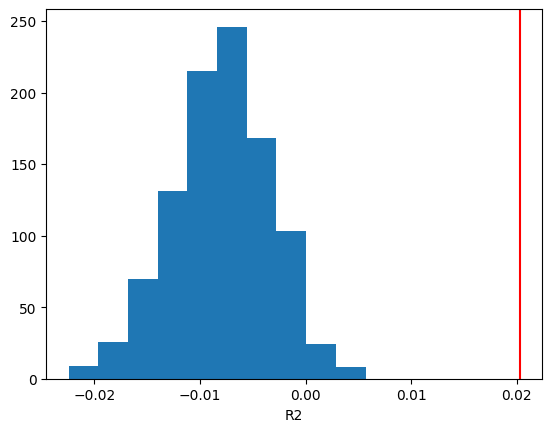

In [13]:
r2_diff = r2_LI_gpt - r2_LI
r2_diff_sorted = np.sort(r2_diff)
idx = 40000
print(r2_diff_sorted[idx])
r2_diff_small_diff = np.argwhere(r2_diff==r2_diff_sorted[idx])

# Let's see what the p-value for this small difference in r2 is 
swapped_scores_small_diff = swapped_r2_LI_gpt[:, r2_diff_small_diff].squeeze()
plt.hist(swapped_scores_small_diff)
plt.axvline(r2_diff_sorted[idx], color='r')
plt.xlabel("R2")

In [ ]:
def r2_difference(model1_preds, model2_preds, ytest, num_permutations=1000):
    
    '''
    ndarray model1_preds: predictions from first model
    ndarray model2_preds: predictions from second, nested model
    ndarray ytest: groundtruth data 
    int num_permutations: number of swaps to do 
    
    Swaps 50% of predictions between model1 and model2, and then recomputes out of sample r2.
    This is done num_permutation times to create a distribution.
    '''

    num_samples = y_test.shape[0]
    num_voxels = y_test.shape[1]
    
    # now try shuffling and recomputing the R2
    swap_number= int(0.5*num_samples)

    swapped_r2 = np.zeros((num_permutations, num_voxels))
    
    for i in range(num_permutations):
        
        if i % 100 == 0:
            print(i)
            
        model1_preds_swapped = copy.deepcopy(model1_preds)
        swap_indices = np.random.choice(num_samples, swap_number, replace=False)
        model1_preds_swapped[swap_indices] = model2_preds[swap_indices]
        mse_LI_gpt_swapped = mean_squared_error(model1_preds_swapped, y_test, multioutput='raw_values')
        r2_swapped = 1 - mse_LI_gpt_swapped/mse_intercept_only
        swapped_r2[i] = r2_swapped
        
    
        
    

        
    

In [ ]:
np.argwher

In [110]:
np.argwhere(r2_LI_gpt>swapped_r2_LI_gpt.mean(axis=0)).shape[0]

28519

In [112]:
swapped_r2_LI_gpt.mean(axis=0).shape

(49760,)

In [111]:
np.argwhere(r2_LI_gpt > r2_LI).shape[0]

28482

Text(0.5, 0, 'Mean of swapped r2 across voxels')

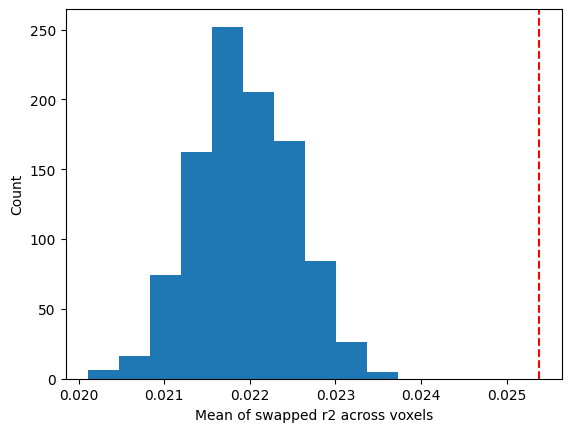

In [106]:
plt.hist(np.mean(swapped_r2_LI_gpt,axis=1))
plt.axvline(r2_LI_gpt.mean(), linestyle='--', color='r')
plt.ylabel("Count")
plt.xlabel("Mean of swapped r2 across voxels")

In [14]:
import numpy as np

def permute_matrix_in_blocks(y_pred, mse_intercept_only, block_size, num_permutations=1000):
    
    permuted_r2 = np.zeros((num_permutations, y_pred.shape[1]))
    
    # Get the number of rows in the y_pred
    num_rows = y_pred.shape[0]
    # Define the block size
    
    # Calculate the number of blocks
    num_blocks = num_rows // block_size
    
    # Create a list of block indices and shuffle them
    block_indices = list(range(num_blocks))
    
    real_r2 = 1 - mean_squared_error(y_pred, y_test, multioutput='raw_values')/mse_intercept_only
    
    print("R2 mean: ", real_r2.mean())
    
    for n in range(num_permutations):
        
        if n % 100 == 0:
            print(n)
        
        np.random.shuffle(block_indices)
        
        # Create an empty y_pred to store the shuffled rows
        shuffled_y_pred = np.empty_like(y_pred)
        
        # Iterate through the shuffled block indices
        for i, block_index in enumerate(block_indices):
            # Calculate the start and end row indices for the current block
            start_row = block_index * block_size
            end_row = start_row + block_size
            
            # Copy the rows from the original y_pred to the shuffled y_pred
            shuffled_y_pred[i * block_size : (i + 1) * block_size, :] = y_pred[start_row:end_row, :]
            
        mse_model = mean_squared_error(shuffled_y_pred, y_test, multioutput='raw_values')
        
        permuted_r2[n] = 1 - mse_model/mse_intercept_only
                    
    return permuted_r2, real_r2

In [15]:
permuted_r2, real_r2  = permute_matrix_in_blocks(y_hat_folds, mse_intercept_only, 
                                          block_size=3, num_permutations=1000)

R2 mean:  0.025380373109780165
0
100
200
300
400
500
600
700
800
900


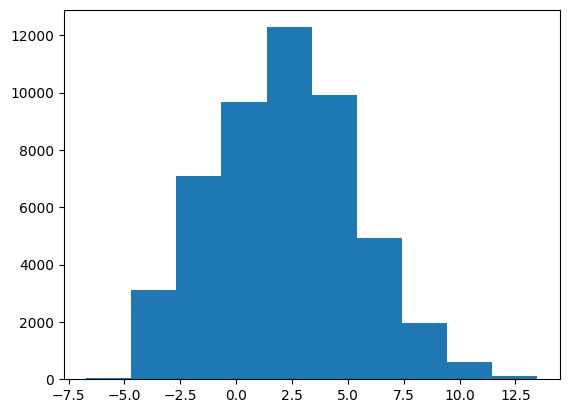

(array([ 12.,  37., 109., 153., 222., 201., 152.,  83.,  24.,   7.]),
 array([-0.07601219, -0.06569983, -0.05538747, -0.04507511, -0.03476275,
        -0.02445039, -0.01413803, -0.00382567,  0.00648668,  0.01679904,
         0.0271114 ]),
 <BarContainer object of 10 artists>)

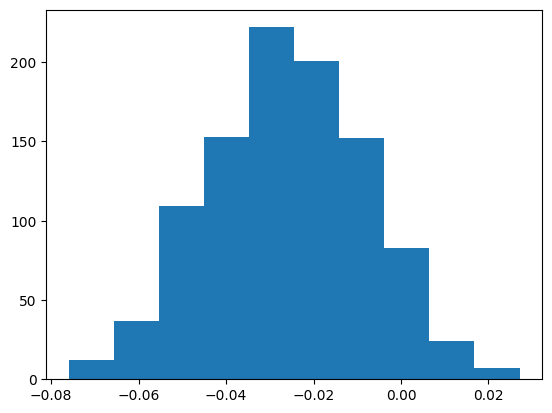

In [19]:
real_r2_z_scored = (real_r2 - np.mean(permuted_r2, axis=0))/np.std(permuted_r2,axis=0)
plt.hist(real_r2_z_scored)
plt.show()
plt.hist(permuted_r2[:, 0])

In [30]:
# find fraction of permuted shuffled r2 that are greater than the real r2
# to compute p-value
num_permutations = 1000
real_less_than_shuffled = real_r2 - permuted_r2
real_less_than_shuffled[real_less_than_shuffled>=0] = 0
real_less_than_shuffled[real_less_than_shuffled<0] = 1
p_vals = np.sum(real_less_than_shuffled,axis=0)/num_permutations
print(p_vals.shape)


(49760,)


In [31]:
np.mean(p_vals)

0.27029993971061095

In [32]:
subjects = np.unique(pereira_data.subject)
networks = np.unique(pereira_data.atlas)

In [33]:
col_to_coord_1 = pereira_data.col_to_coord_1
col_to_coord_2 = pereira_data.col_to_coord_2
col_to_coord_3 = pereira_data.col_to_coord_3

In [34]:
p_vals.shape

(49760,)

In [56]:
p_vals_stored = {}
r2_vals_stored = {}
SPM_dim = (79,95,69)

store_scores_by_network = {}
p_vals_426 = {}
for n in networks:
    store_scores_by_network[n] = []
    
    p_vals_426[n] = []
    for s in subjects:
        
    
        print(s, n)
        
        p_vals_stored[f'{s}_{n}'] = np.full(SPM_dim, np.nan)
        r2_vals_stored[f'{s}_{n}'] = np.full(SPM_dim, np.nan)
        
        
        subj_idxs = np.asarray((pereira_data.subject==s))
        network_idxs = np.asarray((pereira_data.atlas==n))
        subj_network_idxs = np.logical_and(subj_idxs, network_idxs)
        
        p_vals_sn = p_vals[subj_network_idxs]
        r2_vals_sn = real_r2[subj_network_idxs]
        
        store_scores_by_network[n].append(r2_vals_sn.mean())
        
        col_to_coord_1_sn = np.array(col_to_coord_1[subj_network_idxs])
        col_to_coord_2_sn = np.array(col_to_coord_2[subj_network_idxs])
        col_to_coord_3_sn = np.array(col_to_coord_3[subj_network_idxs])
        
        p_vals_426[n].extend(p_vals_sn)
        
        for i, (x,y,z) in enumerate(zip(col_to_coord_1_sn, col_to_coord_2_sn, col_to_coord_3_sn)):
            p_vals_stored[f'{s}_{n}'][x,y,z] = p_vals_sn[i]
            r2_vals_stored[f'{s}_{n}'][x,y,z] = r2_vals_sn[i]


018 DMN
288 DMN
289 DMN
296 DMN
426 DMN
018 MD
288 MD
289 MD
296 MD
426 MD
018 auditory
288 auditory
289 auditory
296 auditory
426 auditory
018 language
288 language
289 language
296 language
426 language
018 visual
288 visual
289 visual
296 visual
426 visual


In [62]:
np.savez(f'/data/LLMs/Pereira/stats_results/{key}_r2', **r2_vals_stored)
np.savez(f'/data/LLMs/Pereira/stats_results/{key}_pval', **p_vals_stored)

In [49]:
store_scores_by_network['language']

[0.0341913461395688,
 -0.006373673473101229,
 0.07886220464309841,
 0.03627300177686063,
 0.14858623844338628]

(array([4772.,  225.,  175.,  153.,  112.,  122.,  124.,  139.,  163.,
         684.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

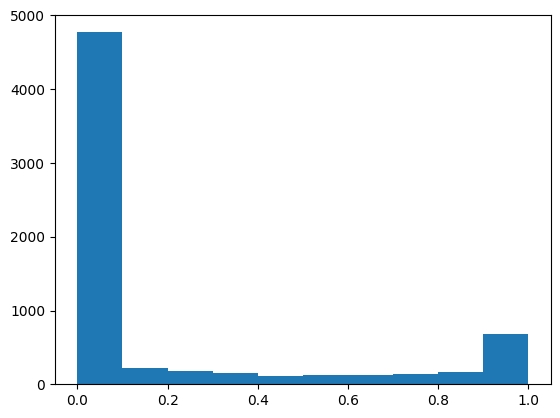

In [57]:
plt.hist(p_vals_426['language'])

(array([1027.,  243.,  144.,  107.,  105.,  121.,  102.,  100.,  162.,
         780.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

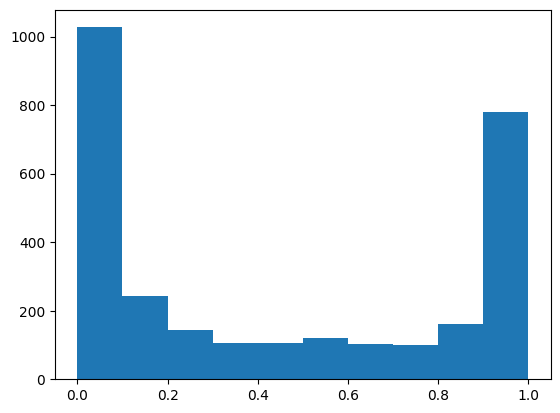

In [58]:
plt.hist(p_vals_426['auditory'])